



### Must use Tensorflow Kernel 
-- conda_amzonei_tensorflow_p36
--- The MXNet code won't work with this kernal...

with the other MXNet kernal, the keras code in this notebook wouldn't work...




In [2]:
import pandas as pd
from pandas import read_csv
from pandas import datetime
import numpy as np
from time import time
import itertools

#misc
import string
from functools import partial
from collections import defaultdict 

#Plotting

import matplotlib 
from matplotlib import pyplot as plt

%matplotlib inline

#NLP

import nltk

from pickle import load

from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn

#Sci-kit Learn

import sklearn

from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.linear_model import RidgeClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.svm import LinearSVC

from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid

from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.base import BaseEstimator,TransformerMixin

from sklearn import metrics
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score  
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#Keras
import keras

from keras.preprocessing.text import Tokenizer

from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers import LSTM
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential 

#AWS
import boto3
from sagemaker import get_execution_role


Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [3]:
# nltk/NLP support

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
role = get_execution_role()
bucket='capstonea'
#bucket='sagemaker-david-sara-jeff'
data_key = 'train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_csv(data_location)

# check the structure

print("number of rows: {0}".format(df.shape[0]))
print("number of columns: {0}".format(df.shape[1]))

df.head()

number of rows: 159571
number of columns: 8


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Check the structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
# check the structure
df.describe().T

,count,mean,std,min,25%,50%,75%,max
toxic,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
severe_toxic,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
obscene,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
insult,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
identity_hate,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


In [7]:
# add temp field for aggregation of toxic flags
df['temp1'] = df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df ['insult'] + df['identity_hate']

# add consolidated Toxic feature
df['toxic'] = np.where(df['temp1'] ==0,0,1)

#drop unneccessary columns

df = df.drop(columns=['severe_toxic','obscene','threat','insult','identity_hate', 'temp1'], axis=1)

df.head()

,id,comment_text,toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


In [8]:
# Check valid unique values per column
df.groupby('toxic')['toxic'].count().sort_values(ascending=False)

toxic
0    143346
1     16225
Name: toxic, dtype: int64

In [9]:
#df = df[:10000]

In [10]:
# Check valid unique values per column
df.groupby('toxic')['toxic'].count().sort_values(ascending=False)

toxic
0    143346
1     16225
Name: toxic, dtype: int64

In [11]:
class NLTKPreprocesor(BaseEstimator,TransformerMixin):
    # here, we are defining the initial condition of the class
    def __init__(self,stopwords = None,punct = None,lower = True,strip=True):
        self.lower = lower
        self.strip = strip
        self.stopwords = stopwords or set(sw.words('english'))
#        self.punct = punct or set(string.punctuation)
        self.lemmatizer = WordNetLemmatizer()


    def fit(self,X,y=None):
        return self

    def inverse_transform(self,X):
        pass

    def transform(self,X):
        return [list(self.tokenize(doc)) for doc in X]
    
    # This is the funciton that break (text) into individual linguistic units.
    def tokenize(self,sDocument):
        document=sDocument

        for sent in sent_tokenize(document):
            for token,tag in pos_tag(wordpunct_tokenize(sent)):
                token = token.lower() if self.lower else token
                token = token.strip() if self.strip else token
#                token = token.strip('_') if self.strip else token
#                token = token.strip('*') if self.strip else token
#                token = token.strip('#') if self.strip else token

                if token in self.stopwords:
                    continue

#                if all(char in self.punct for char in token):
#                    continue

                if len(token) <= 0:
                    continue

                lemma = self.lemmatize(token,tag)
                yield lemma

    def lemmatize(self,token,tag):
        tag ={
            'N' : wn.NOUN,
            'V' : wn.VERB,
            'R' : wn.ADV,
            'J' : wn.ADJ
        }.get(tag[0],wn.NOUN)
        return self.lemmatizer.lemmatize(token,tag)


def prepare_data(X,X_t):
    preProcess = Pipeline([
        ('NLTKpreprocess', NLTKPreprocesor()),
        ('vectorizer', TfidfVectorizer(
            max_df=0.90,
            max_features=20000, #was 5k
            encoding='latin1',
            tokenizer=lambda x: x,
            preprocessor=None, lowercase=False))
    ])
    x_train = np.asanyarray(preProcess.fit_transform(X.values).todense())

    x_test = np.asanyarray(preProcess.transform(X_t.values).todense())

    return x_train,x_test,preProcess


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

In [12]:
%%time

if __name__ == '__main__':
    data = df
    clf = NLTKPreprocesor()
    procData = clf.transform(data.loc[:, 'comment_text']) ## preprocessing the comments ##

CPU times: user 11min 42s, sys: 4.36 s, total: 11min 46s
Wall time: 11min 46s


In [13]:
pData=np.asarray(procData)
print(pData.shape[:])
print(data.loc[:,'toxic'].shape[:])

(159571,)
(159571,)


In [14]:
list_classes = ["toxic"]
X_train, X_test, y_train, y_test=train_test_split(pData, data.loc[:,'toxic'], shuffle=False, test_size=0.2)

In [15]:
toxicX_train=[]
NonToxic_train=[]
for i,comment in enumerate(X_train):
    if int(y_train[i])==1:
        toxicX_train.append(comment)
    else:
        NonToxic_train.append(comment)

In [16]:
ptoxicX_train=np.asarray(toxicX_train)
print(ptoxicX_train.shape[:])

(13000,)


In [17]:
pNonToxic_train=np.asarray(NonToxic_train)
print(pNonToxic_train.shape[:])

(114656,)


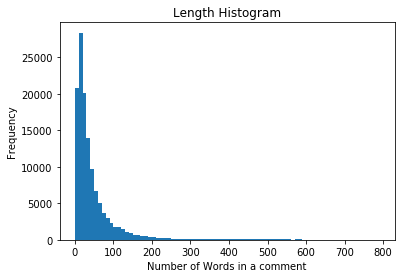

In [18]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = np.arange(0,800,10))
plt.title("Length Histogram")
plt.xlabel("Number of Words in a comment")
plt.ylabel("Frequency")
plt.show()

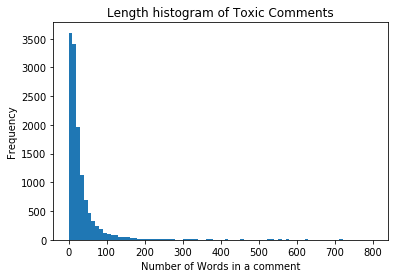

In [19]:
plt.clf()
ToxicNumWords = [len(one_comment) for one_comment in toxicX_train]
plt.hist(ToxicNumWords,bins = np.arange(0,810,10))
plt.title("Length histogram of Toxic Comments")
plt.xlabel("Number of Words in a comment")
plt.ylabel("Frequency")
plt.show()

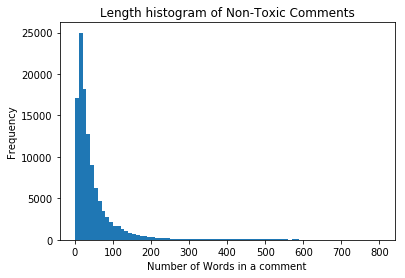

In [20]:
plt.clf()
NonToxicNumWords = [len(one_comment) for one_comment in NonToxic_train]
plt.hist(NonToxicNumWords,bins = np.arange(0,810,10))
plt.xlabel("Number of Words in a comment")
plt.title("Length histogram of Non-Toxic Comments")
plt.ylabel("Frequency")
plt.show()

In [21]:
print("Total Words in Toxic Comments",np.asarray(ToxicNumWords).sum())
print("Average Word Count in Toxic Comments",np.asarray(ToxicNumWords).mean())
print("Max Word Count in Toxic Comments",np.asarray(ToxicNumWords).max())
toxic_text_train=[]
for x in toxicX_train:
    x=' '.join(x)
    toxic_text_train.append(x.encode('utf-8'))

toxic_text_train=np.asarray(toxic_text_train)

Total Words in Toxic Comments 514478
Average Word Count in Toxic Comments 39.57523076923077
Max Word Count in Toxic Comments 1386


In [22]:
print ("Total Words in Non-Toxic Comments",np.asarray(NonToxicNumWords).sum())
print ("Average Word count in Non-Toxic Comments",np.asarray(NonToxicNumWords).mean())
print ("Max Word count in Non-Toxic Comments",np.asarray(NonToxicNumWords).max())
ntoxic_text_train=[]
for x in NonToxic_train:
    x=' '.join(x)
    ntoxic_text_train.append(x.encode('utf-8'))

ntoxic_text_train=np.asarray(ntoxic_text_train)

Total Words in Non-Toxic Comments 5749635
Average Word count in Non-Toxic Comments 50.146830519118055
Max Word count in Non-Toxic Comments 1428


In [23]:
print("Total Number of Words in all Comments",np.asarray(totalNumWords).sum())
print("Average Word count in all Comments",np.asarray(totalNumWords).mean())
print("Max Word count in all Comments",np.asarray(totalNumWords).max())
text_train=[]
for x in X_train:
    x=' '.join(x)
    text_train.append(x.encode('utf-8'))

text_test=[]
for x in X_test:
    x=' '.join(x)
    text_test.append(x.encode('utf-8'))
text_train=np.asarray(text_train)
text_test=np.asarray(text_test)

Total Number of Words in all Comments 6264113
Average Word count in all Comments 49.07025913392242
Max Word count in all Comments 1428


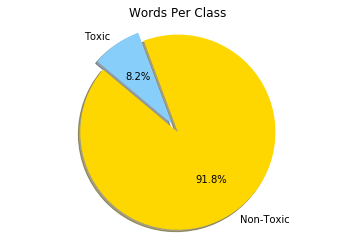

In [24]:

 
# Data to plot
labels ='Non-Toxic', 'Toxic'
title="Words Per Class"

sizes = [np.asarray(NonToxicNumWords).sum(),np.asarray(ToxicNumWords).sum()]
colors = ['gold', 'lightskyblue']#, 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title(title)  
plt.axis('equal')
plt.show()

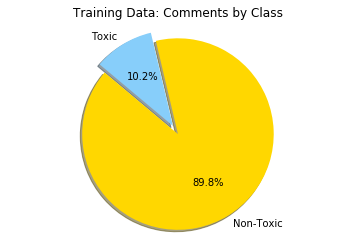

In [25]:
a= len(toxicX_train)
b= len(pNonToxic_train)

# Data to plot
labels ='Non-Toxic', 'Toxic'
title="Training Data: Comments by Class"

sizes = [b,a]
colors = ['gold', 'lightskyblue']#, 'lightcoral', 'lightskyblue']
explode = (0.1, 0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title(title) 
plt.axis('equal')
plt.show()

In [26]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
list_text_train=[]
L=np.asarray(text_train).tolist()
for i in range(len(L)):
    list_text_train.append(str(L[i]))
    
tokenizer.fit_on_texts(list_text_train)

In [27]:
import operator
z=tokenizer.word_counts
sorted_tokens = sorted(z.items(), key=operator.itemgetter(1))
L=len(sorted_tokens)
print("Popular words in non-labeled Comments")
print(L)
for i in range(L-1,L-40,-1):
    print(sorted_tokens[i])

Popular words in non-labeled Comments
162568
("'", 244991)
('article', 58942)
('page', 45612)
("b'", 44103)
('wikipedia', 38656)
('b', 38652)
('talk', 31794)
('use', 26248)
('xe2', 24574)
('one', 24563)
('make', 24116)
('would', 23100)
('edit', 22933)
('please', 22921)
('like', 22860)
('x80', 21332)
('see', 20217)
('say', 20149)
('think', 19244)
('know', 18866)
('source', 18623)
('get', 17226)
('go', 16964)
('also', 16133)
('add', 15506)
('time', 15421)
('people', 15091)
('user', 14556)
('good', 13263)
('block', 12673)
('may', 12525)
('need', 12444)
('take', 12175)
('link', 11937)
('image', 11927)
('want', 11890)
('name', 11699)
('delete', 11698)
('find', 11281)


In [28]:
ToxicTokenizer = Tokenizer(num_words=max_features)
list_toxic_text_train=[]
L=np.asarray(toxic_text_train).tolist()
for i in range(len(L)):
    list_toxic_text_train.append(str(L[i]))

ToxicTokenizer.fit_on_texts(list(np.asarray(list_toxic_text_train)))

In [29]:
tz=ToxicTokenizer.word_counts
toxic_sorted_tokens = sorted(tz.items(), key=operator.itemgetter(1))

In [30]:
tL=len(toxic_sorted_tokens)
#print L
print("Popular words in Toxic Comments")
for i in range(tL-1,tL-20,-1):
    print(toxic_sorted_tokens[i])

Popular words in Toxic Comments
("'", 21414)
('fuck', 9074)
('b', 4190)
('suck', 3739)
('like', 3279)
('wikipedia', 3277)
('shit', 3254)
('go', 3206)
('nigger', 2972)
('u', 2832)
('get', 2559)
("b'", 2350)
('page', 2270)
('die', 2105)
('know', 2068)
('bitch', 2018)
('gay', 1968)
('faggot', 1917)
('moron', 1859)


In [31]:
NonToxicTokenizer = Tokenizer(num_words=max_features)
list_ntoxic_text_train=[]
L=np.asarray(ntoxic_text_train).tolist()
for i in range(len(L)):
    list_ntoxic_text_train.append(str(L[i]))

NonToxicTokenizer.fit_on_texts(list(np.asarray(list_ntoxic_text_train)))

In [32]:
ntz=NonToxicTokenizer.word_counts
ntoxic_sorted_tokens = sorted(ntz.items(), key=operator.itemgetter(1))

In [33]:
nL = len(ntoxic_sorted_tokens)
print( "Popular words in Non-Toxic Comments")
#print (L)
for i in range(nL-1,nL-20,-1):
    print (ntoxic_sorted_tokens[i])

Popular words in Non-Toxic Comments
("'", 223577)
('article', 57248)
('page', 43342)
("b'", 41753)
('wikipedia', 35379)
('b', 34462)
('talk', 30237)
('use', 25407)
('xe2', 23525)
('one', 23156)
('make', 22315)
('would', 22173)
('please', 22167)
('edit', 21633)
('x80', 20509)
('like', 19581)
('see', 19183)
('say', 18567)
('source', 18135)


In [34]:

print(len(toxic_sorted_tokens))
print(len(ntoxic_sorted_tokens))

30025
153837


In [35]:
list_text_train=[]
L=np.asarray(text_train).tolist()
for i in range(len(L)):
    list_text_train.append(str(L[i]))
    
list_text_test=[]
L=np.asarray(text_test).tolist()
for i in range(len(L)):
    list_text_test.append(str(L[i]))    

list_tokenized_train = tokenizer.texts_to_sequences(list_text_train) 
list_tokenized_test = tokenizer.texts_to_sequences(list_text_test)

In [36]:
tfidf= TfidfVectorizer(
            max_df=0.90,
            max_features=20000,
            encoding='latin1',
            preprocessor=None, lowercase=False)
tfidf.fit(list(np.asarray(text_train)))
tfidf_text_train =tfidf.transform(list(np.asarray(text_train)))
tfidf_text_test =tfidf.transform(list(np.asarray(text_test)))
print("Train",tfidf_text_train.shape[:])
print("Test",tfidf_text_test.shape[:])


Train (127656, 20000)
Test (31915, 20000)


In [37]:

nbClf=MultinomialNB()
nbClf.fit(tfidf_text_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [38]:
tfidfPredicted=nbClf.predict(tfidf_text_test)

In [39]:
tfidfPredicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [40]:

METRICS = {
    "confusion_matrix":confusion_matrix,
    "hamming_loss": hamming_loss,
    "accuracy": accuracy_score,
    "precision": precision_score,     
    "recall": recall_score, 
    "f1": f1_score,
    "f2": partial(fbeta_score, beta=2),
}

tfIDF=[]
for i in range(len(tfidfPredicted)):
    tfIDF.append(int(tfidfPredicted[i]))

Y_test=y_test.tolist()
Y=[]
#print()
for i in range(len(y_test)):
#    print(i)#y_test[i])
    Y.append(int(Y_test[i]))
    
    
#fIDF)
records = defaultdict(dict)
list_classes=[]
list_classes.append("toxic")
for metric_name,metric in METRICS.items():
    for j in range(len(list_classes)):
#        print(j)
#        print(metric(y_test,tfidfPredicted))
        print(tfidfPredicted)
        
#        print(y_test)
        records[metric_name][list_classes[j]]=metric(Y,tfIDF) ## Measuring the metrics ##

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [41]:
records

defaultdict(dict, {'confusion_matrix': {'toxic': array([[28606,    84],
                     [ 1705,  1520]])},
             'hamming_loss': {'toxic': 0.056055146482845056},
             'accuracy': {'toxic': 0.943944853517155},
             'precision': {'toxic': 0.9476309226932669},
             'recall': {'toxic': 0.47131782945736433},
             'f1': {'toxic': 0.6295299233795817},
             'f2': {'toxic': 0.5239933811362383}})

In [42]:
# Pretty printing of the metrics #
from pprint import pprint
pprint(dict(records))

{'accuracy': {'toxic': 0.943944853517155},
 'confusion_matrix': {'toxic': array([[28606,    84],
       [ 1705,  1520]])},
 'f1': {'toxic': 0.6295299233795817},
 'f2': {'toxic': 0.5239933811362383},
 'hamming_loss': {'toxic': 0.056055146482845056},
 'precision': {'toxic': 0.9476309226932669},
 'recall': {'toxic': 0.47131782945736433}}


In [43]:
## Use sklearn notes: link: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
## Confusion matrix plotter ## 


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[28606    84]
 [ 1705  1520]]


<Figure size 432x288 with 0 Axes>

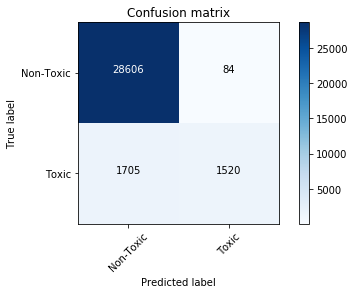

In [44]:
plt.clf()
plt.figure()
plot_confusion_matrix(records["confusion_matrix"]["toxic"],["Non-Toxic","Toxic"])

Normalized confusion matrix
[[0.99707215 0.00292785]
 [0.52868217 0.47131783]]


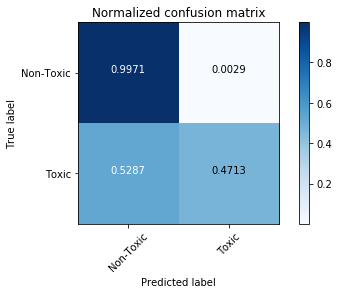

In [45]:
plt.figure()
plot_confusion_matrix(records["confusion_matrix"]["toxic"],["Non-Toxic","Toxic"],normalize=True,title='Normalized confusion matrix')
plt.show()

In [109]:
maxlength=200 #was 100
paddedTrain=pad_sequences(list_tokenized_train,maxlen=maxlength) # Padding the traning section
paddedTest=pad_sequences(list_tokenized_test,maxlen=maxlength) # Padding the testing section

In [110]:
def LSTM_Classifier(embDim=128, lstmDim=60, hidDim=50, outDim=1, maxlen=maxlength, max_features=20000):
    model=Sequential()
    model.add(Embedding(max_features, embDim, input_length=maxlen))
    model.add(LSTM(lstmDim, return_sequences=True, name='lstm_layer'))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.1))
    model.add(Dense(hidDim, activation='relu')) #tried tanh
    model.add(Dropout(0.1))
    model.add(Dense(outDim, activation='sigmoid')) #tried tanh
#    model=Model(inp,x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', 'mean_squared_error'])
#    model.summary()
    return model

In [111]:
# Importing LSTM Classifier,
#I have written a function for making the architecture using the given inputs for LSTM classifier #
checkCLF=LSTM_Classifier(embDim=128, lstmDim=60, hidDim=50, outDim=1, maxlen=maxlength)
checkCLF.summary()
Path='weights.best.RNN.' # I saved the trained weights for extended use and transfer learning # 
checkpoint=ModelCheckpoint(filepath=Path,
                           verbose=1, save_best_only=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 60)                0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                3050      
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                

In [112]:
%%time
epochs=5
history=checkCLF.fit(paddedTrain, y_train, validation_split=0.1,
                epochs=epochs,
                batch_size=100, #was 256
                callbacks=[checkpoint], verbose=1 
                )

Train on 114890 samples, validate on 12766 samples
Epoch 1/5
114890/114890 [==============================] - 155s 1ms/step - loss: 0.1637 - accuracy: 0.9436 - mean_squared_error: 0.0458 - val_loss: 0.1112 - val_accuracy: 0.9614 - val_mean_squared_error: 0.0308

Epoch 00001: val_loss improved from inf to 0.11118, saving model to weights.best.RNN.
Epoch 2/5
114890/114890 [==============================] - 154s 1ms/step - loss: 0.0946 - accuracy: 0.9652 - mean_squared_error: 0.0265 - val_loss: 0.1159 - val_accuracy: 0.9588 - val_mean_squared_error: 0.0317

Epoch 00002: val_loss did not improve from 0.11118
Epoch 3/5
114890/114890 [==============================] - 154s 1ms/step - loss: 0.0744 - accuracy: 0.9728 - mean_squared_error: 0.0209 - val_loss: 0.1239 - val_accuracy: 0.9588 - val_mean_squared_error: 0.0326

Epoch 00003: val_loss did not improve from 0.11118
Epoch 4/5
114890/114890 [==============================] - 154s 1ms/step - loss: 0.0550 - accuracy: 0.9793 - mean_squared_err

In [113]:
%%time

BestTrainPred=checkCLF.predict(paddedTrain) ## Predicting the results for test and training section using trained LSTM Classifier ##
BestTestPred=checkCLF.predict(paddedTest)

CPU times: user 6min 25s, sys: 46.2 s, total: 7min 11s
Wall time: 1min 47s


In [114]:
## binary formatting the probability predictions ## 
# Setting the threshhold 0.5 #
BinaryTrainPred=np.zeros(BestTrainPred.shape[:])
BinaryTestPred=np.zeros(BestTestPred.shape[:])

for i in range(len(BestTrainPred)):
    for j in range(1):
        if BestTrainPred[i,j] >= 0.5:
            BinaryTrainPred[i,j]=1
        else:
            BinaryTrainPred[i,j]=0
            
for i in range(len(BestTestPred)):
    for j in range(1):
        if BestTestPred[i,j] >= 0.5:
            BinaryTestPred[i,j]=1
        else:
            BinaryTestPred[i,j]=0

In [115]:
METRICS = {
    "confusion_matrix":confusion_matrix,
    "hamming_loss": hamming_loss,
    "accuracy": accuracy_score,
    "precision": precision_score,     
    "recall": recall_score, 
    "f1": f1_score,
    "f2": partial(fbeta_score, beta=2),
}

ytest=y_test.tolist()
Y=[]
for i in range(len(ytest)):
    Y.append(int(ytest[i]))

records = defaultdict(dict)
list_classes=[]
list_classes.append("toxic")
for metric_name,metric in METRICS.items():
    records[metric_name][list_classes[0]]=metric(Y,BinaryTestPred[:,0])

In [116]:

pprint(dict(records))

{'accuracy': {'toxic': 0.951088829703901},
 'confusion_matrix': {'toxic': array([[28028,   662],
       [  899,  2326]])},
 'f1': {'toxic': 0.7487526154836633},
 'f2': {'toxic': 0.7319989929506545},
 'hamming_loss': {'toxic': 0.04891117029609901},
 'precision': {'toxic': 0.7784471218206158},
 'recall': {'toxic': 0.7212403100775194}}


Confusion matrix, without normalization
[[28028   662]
 [  899  2326]]


<Figure size 432x288 with 0 Axes>

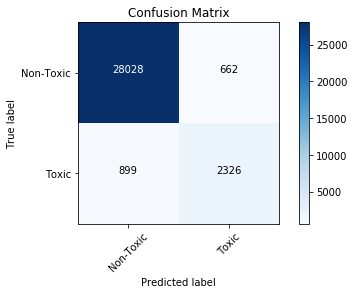

In [117]:
plt.clf()
plt.figure()
plot_confusion_matrix(records["confusion_matrix"]["toxic"],["Non-Toxic","Toxic"],normalize=False,title='Confusion Matrix')
plt.show()